## Site Percolation

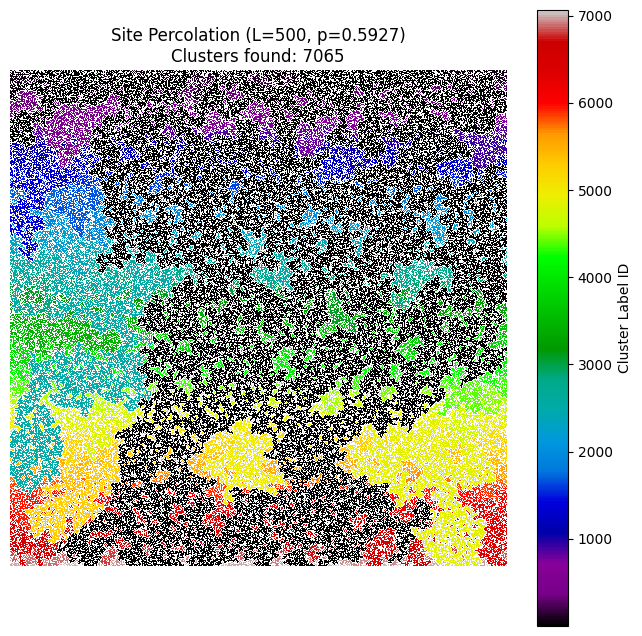

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

def simulate_site_percolation(L, p):
    """
    Simulates site percolation on a square lattice.
    
    Args:
        L (int): Linear dimension of the lattice (L x L).
        p (float): Occupation probability.
        
    Returns:
        lattice (ndarray): Boolean array of occupied sites.
        labeled_lattice (ndarray): Array where connected clusters have unique integers.
        num_clusters (int): Total number of clusters found.
    """
    # 1. Generate random grid
    # Draw random numbers; if < p, the site is occupied (True)
    random_grid = np.random.rand(L, L)
    lattice = random_grid < p
    
    # 2. Label connected clusters
    # structure defines connectivity: [[0,1,0],[1,1,1],[0,1,0]] is 4-neighbor (von Neumann)
    structure = [[0, 1, 0],
                 [1, 1, 1],
                 [0, 1, 0]]
                 
    labeled_lattice, num_clusters = label(lattice, structure=structure)
    
    return lattice, labeled_lattice, num_clusters

# --- Parameters ---
L = 500       # Lattice size
p = 0.5927   # Near the critical threshold (approx 0.592746 for site percolation)

# --- Run Simulation ---
lattice, labeled_lattice, n_clusters = simulate_site_percolation(L, p)

# --- Visualization ---
plt.figure(figsize=(8, 8))
plt.title(f"Site Percolation (L={L}, p={p})\nClusters found: {n_clusters}")

# We mask the background (0) to make it white/distinct
masked_data = np.ma.masked_where(labeled_lattice == 0, labeled_lattice)

# Plot using a colormap (e.g., 'nipy_spectral' or 'tab20')
plt.imshow(masked_data, cmap='nipy_spectral', interpolation='nearest')
plt.colorbar(label='Cluster Label ID')
plt.axis('off')
plt.show()

## Bond Percolation
The code below gives faster computation time when `L` is large

Simulating Bond Percolation for L=1000...
Analyzing clusters...


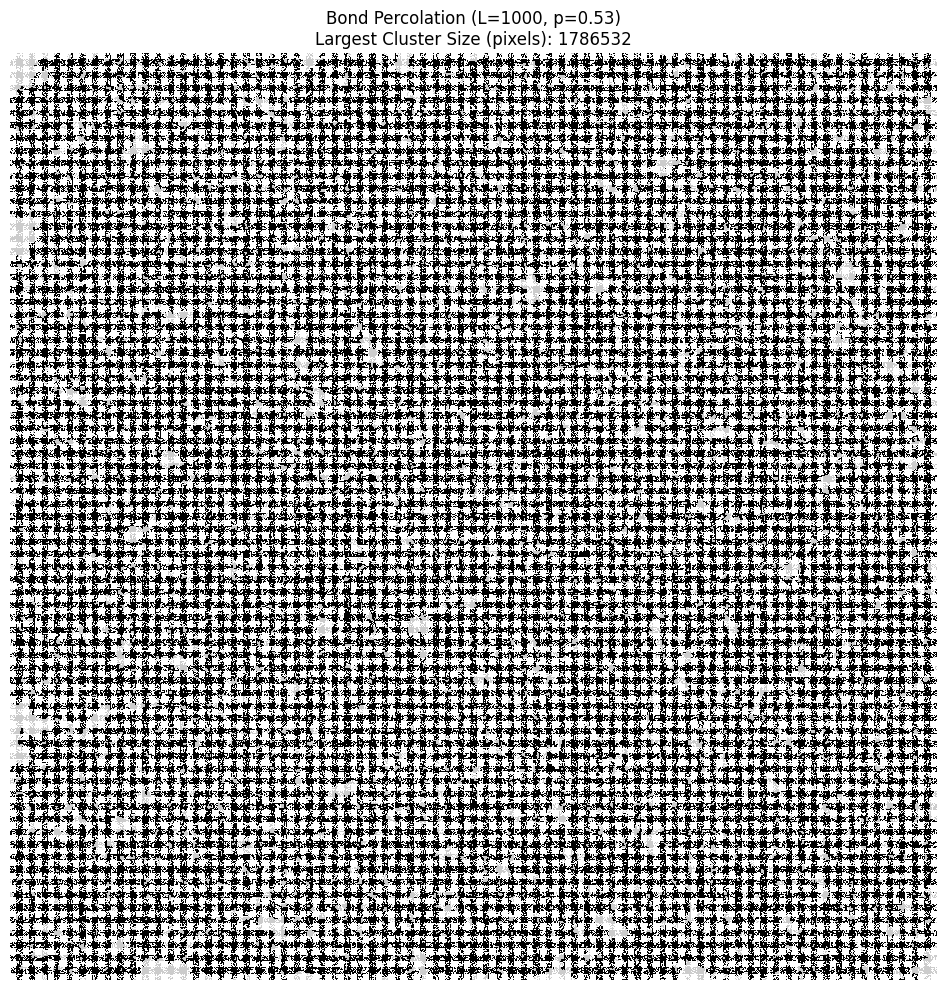

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

def simulate_bond_percolation_optimized(L, p):
    """
    Simulates bond percolation on a square lattice using a super-lattice array.
    This is O(N) and works efficiently for L=1000+.
    
    Returns:
        labeled_array (ndarray): Array where connected clusters have unique IDs.
    """
    # 1. Create a Super-Lattice (2L+1 x 2L+1)
    # Even indices are Sites, Odd indices are Bonds.
    shape = (2 * L + 1, 2 * L + 1)
    
    # Initialize lattice: False (Empty/White)
    super_lattice = np.zeros(shape, dtype=bool)
    
    # 2. Activate all Sites (at even coordinates)
    # Sites are deterministic: they always exist.
    super_lattice[0::2, 0::2] = True
    
    # 3. Activate Bonds (at mixed coordinates) probabilistically
    # Horizontal Bonds: located at (Even, Odd)
    # Size is (L+1) rows x L cols
    h_bonds = np.random.rand(L + 1, L) < p
    super_lattice[0::2, 1::2] = h_bonds
    
    # Vertical Bonds: located at (Odd, Even)
    # Size is L rows x (L+1) cols
    v_bonds = np.random.rand(L, L + 1) < p
    super_lattice[1::2, 0::2] = v_bonds
    
    # 4. Find Connected Components
    # We use a standard 3x3 structure for connectivity (von Neumann is sufficient here)
    structure = [[0, 1, 0], 
                 [1, 1, 1], 
                 [0, 1, 0]]
    
    labeled_array, num_features = label(super_lattice, structure=structure)
    
    return labeled_array

# --- Parameters ---
L = 1000        # Large grid
p = 0.530       # Critical threshold

# --- Run Simulation ---
print(f"Simulating Bond Percolation for L={L}...")
labeled_array = simulate_bond_percolation_optimized(L, p)

# --- Analyze Clusters ---
print("Analyzing clusters...")
# Flatten the array to count occurrences of each label (cluster size)
# We ignore label 0 (background)
flat_labels = labeled_array.ravel()
flat_labels = flat_labels[flat_labels > 0] 

if flat_labels.size > 0:
    # bincount is much faster than standard sorting for integers
    counts = np.bincount(flat_labels)
    # The index with the highest count is the largest cluster label
    largest_cluster_label = counts.argmax()
    largest_cluster_size = counts[largest_cluster_label]
else:
    largest_cluster_label = -1
    largest_cluster_size = 0

# --- Visualization Construction ---
# We manually construct an RGB image to match your color scheme:
# Background = White, Small Clusters = LightGray, Largest Cluster = Black

# Initialize RGB array (Height, Width, 3) filled with White (1.0)
H, W = labeled_array.shape
image = np.ones((H, W, 3)) 

# Create masks
mask_occupied = (labeled_array > 0)
mask_largest = (labeled_array == largest_cluster_label)

# Apply "LightGray" (e.g., [0.8, 0.8, 0.8]) to all occupied sites
image[mask_occupied] = [0.8, 0.8, 0.8] 

# Apply "Black" (e.g., [0, 0, 0]) to the largest cluster
image[mask_largest] = [0, 0, 0]

# --- Plotting ---
plt.figure(figsize=(10, 10), dpi=100) # dpi=100 keeps it efficient
plt.title(f"Bond Percolation (L={L}, p={p})\nLargest Cluster Size (pixels): {largest_cluster_size}")
plt.imshow(image, interpolation='nearest')
plt.axis('off')
plt.tight_layout()
plt.show()

## Video

Allocating memory and generating random thresholds...


Rendering Video:   0%|          | 0/1000 [00:00<?, ?frame/s]

Starting rendering of 1000 frames...


Rendering Video: 1003frame [26:10,  1.57s/frame]                       



Done! Video saved as percolation_evolution_L1000.mp4


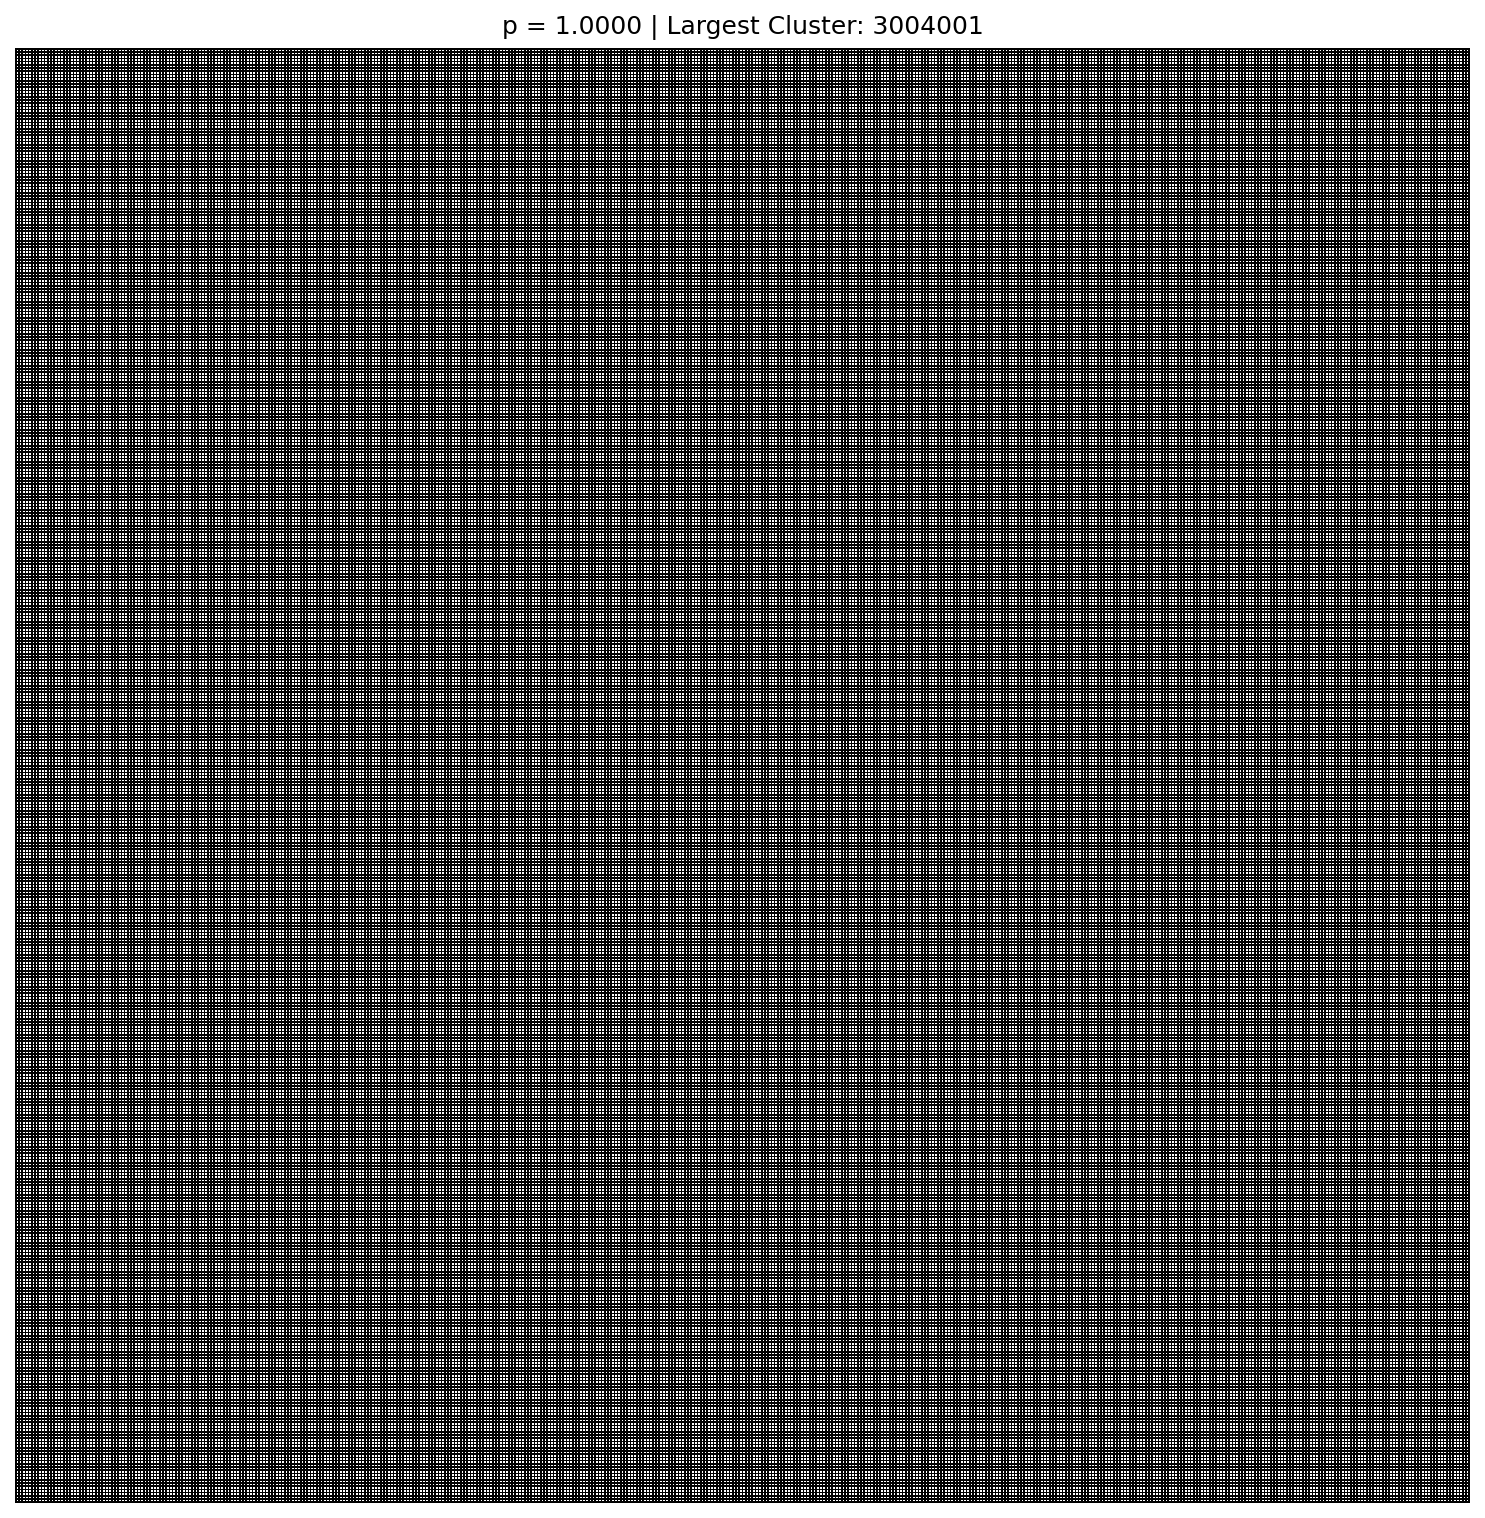

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from scipy.ndimage import label
from tqdm import tqdm
import imageio_ffmpeg

# --- Configuration ---
L = 1000               # Grid size
TOTAL_FRAMES = 1000    # Total steps (increased for smoother video)
FPS = 60              # Frame rate of output video
# OUTPUT_FILENAME = "percolation_evolution_L100.mp4"
OUTPUT_FILENAME = "percolation_evolution_L1000.mp4"

# --- Configure ffmpeg path ---
plt.rcParams['animation.ffmpeg_path'] = imageio_ffmpeg.get_ffmpeg_exe()

# --- 1. Pre-compute Random Thresholds (The "DNA" of the system) ---
print("Allocating memory and generating random thresholds...")
# Set seed for reproducibility
np.random.seed(42)

shape = (2 * L + 1, 2 * L + 1)

# Fixed sites (always active)
sites_mask = np.zeros(shape, dtype=bool)
sites_mask[0::2, 0::2] = True

# Random values for bonds. 
threshold_map = np.full(shape, 2.0, dtype=np.float32)

# Horizontal Bonds (Even row, Odd col)
h_rnd = np.random.rand(L + 1, L)
threshold_map[0::2, 1::2] = h_rnd

# Vertical Bonds (Odd row, Even col)
v_rnd = np.random.rand(L, L + 1)
threshold_map[1::2, 0::2] = v_rnd

# Structure for labeling (von Neumann neighborhood)
structure = [[0, 1, 0], 
             [1, 1, 1], 
             [0, 1, 0]]

# --- 2. Setup Plotting Environment ---
# dpi=150 is sufficient for L=100 (200x200 grid)
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)

# Initialize with a blank image
initial_data = np.ones((shape[0], shape[1], 3)) # Start white
# Use nearest interpolation to avoid blurring
im = ax.imshow(initial_data, interpolation='nearest', animated=True)
title_text = ax.text(0.5, 1.01, "", transform=ax.transAxes, ha="center", fontsize=12)
ax.axis('off')
plt.tight_layout()

# --- 3. The Update Function ---
# Initialize cumulative mask for "monotonic" visualization
# This tracks any site that has EVER been part of the largest cluster.
cumulative_largest_mask = np.zeros(shape, dtype=bool)

pbar = tqdm(total=TOTAL_FRAMES, unit="frame", desc="Rendering Video")

def update(frame_idx):
    global cumulative_largest_mask
    
    # Calculate current p
    p = frame_idx / (TOTAL_FRAMES - 1)
    
    # 1. Build the lattice for this specific p
    # This logic is strictly monotonic: as p increases, more sites/bonds turn True.
    super_lattice = (threshold_map < p) | sites_mask
    
    # 2. Cluster Labeling
    labeled_array, num_features = label(super_lattice, structure=structure)
    
    # 3. Analysis (Find largest cluster)
    largest_cluster_size = 0
    largest_cluster_label = -1
    
    if num_features > 0:
        flat_labels = labeled_array.ravel()
        flat_labels = flat_labels[flat_labels > 0] # Filter out 0 (background)
        
        if flat_labels.size > 0:
            counts = np.bincount(flat_labels)
            largest_cluster_label = counts.argmax()
            largest_cluster_size = counts[largest_cluster_label]
    
    # 4. Color Mapping
    color_layer = np.ones((shape[0], shape[1], 3), dtype=np.float32)
    
    if num_features > 0:
        mask_occupied = (labeled_array > 0)
        mask_largest = (labeled_array == largest_cluster_label)
        
        # Update Cumulative Mask (Enforce Monotonicity of "Black" Region)
        # Once a site is part of the largest cluster, it stays Black.
        # This prevents the "disappearing" effect when the largest cluster ID switches.
        cumulative_largest_mask = cumulative_largest_mask | mask_largest
        
        # Color all occupied sites Dark Gray
        color_layer[mask_occupied] = [0.4, 0.4, 0.4]
        
        # Color cumulative largest cluster(s) Black
        color_layer[cumulative_largest_mask] = [0.0, 0.0, 0.0]
    
    # 5. Update Plot
    im.set_data(color_layer)
    title_text.set_text(f"p = {p:.4f} | Largest Cluster: {largest_cluster_size}")
    
    pbar.update(1)
    return im, title_text

# --- 4. Run Animation ---
print(f"Starting rendering of {TOTAL_FRAMES} frames...")
ani = FuncAnimation(fig, update, frames=TOTAL_FRAMES, blit=True)

# Save
writer = FFMpegWriter(fps=FPS, bitrate=5000) 
ani.save(OUTPUT_FILENAME, writer=writer)

pbar.close()
print(f"Done! Video saved as {OUTPUT_FILENAME}")